In [2]:
import Pkg; Pkg.add("ReverseDiff")

    Updating registry at `~/anaconda3/envs/julia_env/share/julia/registries/General.toml`
   Resolving package versions...
    Updating `~/anaconda3/envs/julia_env/share/julia/environments/julia_env/Project.toml`
  [37e2e3b7] + ReverseDiff v1.14.5
  No Changes to `~/anaconda3/envs/julia_env/share/julia/environments/julia_env/Manifest.toml`


In [3]:
using Flux, DiffEqFlux, DifferentialEquations, Statistics, Plots, ReverseDiff

t = range(0.0f0, 1.0f0, length = 1024)
π_32 = Float32(π)
q_t = reshape(sin.(2π_32 * t), 1, :)
p_t = reshape(cos.(2π_32 * t), 1, :)
dqdt = 2π_32 .* p_t
dpdt = -2π_32 .* q_t

data = cat(q_t, p_t, dims = 1)
target = cat(dqdt, dpdt, dims = 1)
dataloader = Flux.Data.DataLoader((data, target); batchsize=256, shuffle=true)

4-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=256)
  with first element:
  (2×256 Matrix{Float32}, 2×256 Matrix{Float32},)

In [4]:
hnn = HamiltonianNN(
    Chain(Dense(2, 64, relu), Dense(64, 1))
)

p = hnn.p

opt = ADAM(0.01)

loss(x, y, p) = mean((hnn(x, p) .- y) .^ 2)

callback() = println("Loss Neural Hamiltonian DE = $(loss(data, target, p))")

epochs = 500
for epoch in 1:epochs
    for (x, y) in dataloader
        gs = ReverseDiff.gradient(p -> loss(x, y, p), p)
        Flux.Optimise.update!(opt, p, gs)
    end
    if epoch % 100 == 1
        callback()
    end
end
callback()

Loss Neural Hamiltonian DE = 16.757278
Loss Neural Hamiltonian DE = 0.017348167
Loss Neural Hamiltonian DE = 0.011240172
Loss Neural Hamiltonian DE = 0.011711262
Loss Neural Hamiltonian DE = 0.010485139
Loss Neural Hamiltonian DE = 0.008581158


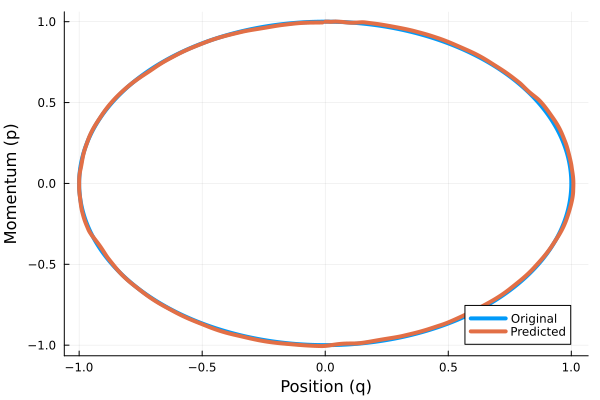

In [5]:
model = NeuralHamiltonianDE(
    hnn, (0.0f0, 1.0f0),
    Tsit5(), save_everystep = false,
    save_start = true, saveat = t
)

pred = Array(model(data[:, 1]))
plot(data[1, :], data[2, :], lw=4, label="Original")
plot!(pred[1, :], pred[2, :], lw=4, label="Predicted")
xlabel!("Position (q)")
ylabel!("Momentum (p)")